#**Odeuropa Nosebook – Textual Smell Trend Analyser (WP3)**
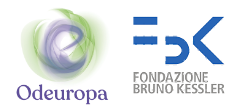

Through this Notebook you will be able to:

1.   Select a dataset your preferred language (English, Italian, German, Dutch, French, Slovene) - Section 1.
2.   See the time distribution of a specific *Smell Source* within the selected dataset - Section 2.
3. Extract occurrences of a specific *Smell Source* within your dataset - Section 3.
4. See the co-occourrences of a specific *Smell Source* within your selected dataset - Section 4.
5. Calculate the [PMI](https://en.wikipedia.org/wiki/Pointwise_mutual_information) of a specific *Smell Source* within your selected dataset  - Section 5.
6. Extract the smell sources appearing more frequently together in specific time spans and save them in an excel file  - Section 6.
7. Find the emotions related to smell sources in specific time spans.


For more details visit https://odeuropa.eu/



# Load Functions


---




> Before playing with the data, click on the arrow close to "*10 cells hidden*". You don't need to do anything else here and go to section "Play with the data"





In [ ]:
!pip install xlsxwriter
!pip install transformers

In [ ]:
from google.colab import files
from google.colab import data_table
from itertools import islice
from IPython.display import clear_output
from tqdm import tqdm
import glob
import re
import ipywidgets as widgets
import math
import os
import pandas as pd
import xlsxwriter
from ipywidgets import interact, interactive, fixed, interact_manual
import functools
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [ ]:
def download_data(lang):
  global df
  filenamedownload = "https://zenodo.org/records/10683359/files/Dataset_"+lang+".tsv"
  filenamesaved = '/content/Dataset_'+lang+'.tsv'
  try:
    !rm {filenamesaved}
  except:
    filenotfound = True
  #!wget -q {filenamedownload}
  !wget {filenamedownload}
  df = pd.read_csv(filenamesaved, sep = '\t')
  df = df.astype({'year':'int'})
  df["sentencewords"] = df["Sentence"].apply(lambda n: len(n.split()))

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def extract_smell_sources_instances(targets,spans,download):

  if download == True:
    filename = "_".join(targets)+"-examples.xlsx"
    writer = pd.ExcelWriter(filename, engine = 'xlsxwriter')
  for span in spans:
    lower_limit,upper_limit = span.split("-")
    targets = [x.lower() for x in targets]
    df_source = df.dropna(subset=['Smell_Source_lemma'])
    pat = '|'.join(r"\b{}\b".format(x) for x in targets)
    df_source = df_source[df_source['Smell_Source_lemma'].str.contains(pat)]
    df_source = df_source.drop(columns=['sentencewords','Quality_lemma','Smell_Source_lemma','Sentence_lemma'])
    df_source = df_source.loc[(df["year"] >= int(lower_limit)) & (df["year"] <= int(upper_limit))]
    if download == True:
      df_source.to_excel(writer, sheet_name=span, index = False)
    else:
      print()
      print('+++++++++++++++++++++++++++++++++')
      print()
      print('Results for '+ str(span) +' span, and targets  '+ str(targets))
      display(data_table.DataTable(df_source[['year','Sentence', 'Smell_Source', 'Quality','Corpus']], include_index=False, num_rows_per_page=10))

  if download == True:
    files.download(filename)
    writer.close()


def extract_smell_sources_cooc(targets, spans, top_n,download):
  if download == True:
    filename = "_".join(targets)+"-cooc.xlsx"
    writer = pd.ExcelWriter(filename, engine = 'xlsxwriter')
  for span in spans:
    lower_limit,upper_limit = span.split("-")
    targets = [x.lower() for x in targets]
    df_source = df.dropna(subset=['Smell_Source_lemma'])
    pat = '|'.join(r"\b{}\b".format(x) for x in targets)
    df_source = df_source[df_source['Smell_Source_lemma'].str.contains(pat)]
    df_source = df_source.loc[(df["year"] >= int(lower_limit)) & (df["year"] <= int(upper_limit))]
    total_words = df_source['sentencewords'].sum()
    df_source = df_source.drop(columns=['sentencewords'])
    freq_cooc = count_form_list(df_source["Sentence_lemma"].dropna().values.tolist())
    freq_cooc_norm = dict()
    for word in freq_cooc:
      if len(word) < 2:
        continue
      freq_cooc_norm[word] = freq_cooc[word] * 1000 / total_words
    df_cooc = pd.DataFrame(take_top(top_n, freq_cooc_norm), columns =['Word', 'Frequency over 1000 words'])
    if download == True:
      df_cooc.to_excel(writer, sheet_name=span, index = False)
    else:
      print()
      print('+++++++++++++++++++++++++++++++++')
      print()
      print('Results for '+ str(span) +' span, and targets  '+ str(targets))
      display(data_table.DataTable(df_cooc, include_index=False))
  if download == True:
    writer.close()
    files.download(filename)


def extract_smell_sources_cooc_window(targets, spans, window_size, top_n,download):
  if download == True:
    filename = "_".join(targets)+"-cooc-window"+str(window_size)+".xlsx"
    writer = pd.ExcelWriter(filename, engine = 'xlsxwriter')
  for span in spans:
    lower_limit,upper_limit = span.split("-")
    targets = [x.lower() for x in targets]
    df_source = df.dropna(subset=['Smell_Source_lemma'])
    pat = '|'.join(r"\b{}\b".format(x) for x in targets)
    df_source = df_source[df_source['Smell_Source_lemma'].str.contains(pat)]
    df_source = df_source.loc[(df["year"] >= int(lower_limit)) & (df["year"] <= int(upper_limit))]
    total_words = df_source['sentencewords'].sum()
    df_source = df_source.drop(columns=['sentencewords','Quality','Smell_Source'])
    freq_cooc = count_form_list_window(df_source["Sentence_lemma"].dropna().values.tolist(),targets,window_size)
    freq_cooc_norm = dict()
    for word in freq_cooc:
      if len(word) < 2:
        continue
      freq_cooc_norm[word] = freq_cooc[word] * 1000 / total_words
    df_cooc = pd.DataFrame(take_top(top_n, freq_cooc_norm), columns =['Word', 'Frequency over 1000 words'])
    if download == True:
      df_cooc.to_excel(writer, sheet_name=span, index = False)
    else:
      print()
      print('+++++++++++++++++++++++++++++++++')
      print()
      print('Results for '+ str(span) +' span, and targets  '+ str(targets))
      display(data_table.DataTable(df_cooc, include_index=False))
  if download == True:
    writer.close()
    files.download(filename)


def count_form_list_window(mylist,targets,window_size):
  freq_dict = dict()
  for sentence in mylist:
    sentence = sentence.split(" ")
    for i,w in enumerate(sentence):
      if str(w) in targets:
        my_window_tokens_list = []
        for span_i in range(i - window_size, i + window_size + 1):
          if span_i >= 0 and  span_i < len(sentence):
            my_window_tokens_list.append(sentence[span_i])
        for word in my_window_tokens_list:
          if word not in freq_dict:
            freq_dict[word] = 0
          freq_dict[word]+=1
  return(freq_dict)


def count_form_list(mylist):
  freq_dict = dict()
  for item in mylist:
    for frame in item.lower().split("|"):
      for word in frame.split(" "):
        if word not in freq_dict:
          freq_dict[word] = 0
        freq_dict[word]+=1
  return(freq_dict)

def pmi_span (targets, spans, top_n, download):
  targets = [x.lower() for x in targets]
  if download ==True:
    filename = "_".join(targets)+"-pmi.xlsx"
    writer = pd.ExcelWriter(filename, engine = 'xlsxwriter')
  for span in spans:

    lower_limit,upper_limit = span.split("-")

    df_selection = df.loc[(df["year"] >= int(lower_limit)) & (df["year"] <= int(upper_limit))]

    total_words = df_selection['sentencewords'].sum()
    freq_quality = count_form_list(df_selection["Quality_lemma"].dropna().values.tolist())

    df_source = df_selection.dropna(subset=['Smell_Source_lemma'])
    pat = '|'.join(r"\b{}\b".format(x) for x in targets)
    df_source = df_source[df_source['Smell_Source_lemma'].str.contains(pat)]

    freq_target = len(df_source)
    freq_cooc = count_form_list(df_source["Quality_lemma"].dropna().values.tolist())

    pmiDict = dict()
    for quality in freq_cooc:
        if freq_cooc[quality] > 5 and len(quality)>0:
          pxy= freq_cooc[quality]/total_words
          px = freq_target/total_words
          py = freq_quality[quality]/total_words
          pmi_value = math.log2(pxy/(px*py))
          pmiDict[quality] = pmi_value
    df_pmi = pd.DataFrame(take_top(top_n, pmiDict), columns =['Quality', 'PMI_score'])

    if download ==True:
      df_pmi.to_excel(writer, sheet_name=span, index = False)
    else:
      print()
      print('+++++++++++++++++++++++++++++++++')
      print()
      print('Results for '+ str(span) +' span, and targets  '+ str(targets))
      display(data_table.DataTable(df_pmi, include_index=False))
  if download ==True:
    writer.close()
    files.download(filename)

# def pmi_span_smell_sources (targets, spans, top_n, download):
#   targets = [x.lower() for x in targets]
#   if download ==True:
#     filename = "_".join(targets)+"-pmi.xlsx"
#     writer = pd.ExcelWriter(filename, engine = 'xlsxwriter')
#   for span in spans:

#     lower_limit,upper_limit = span.split("-")

#     df_selection = df.loc[(df["year"] >= int(lower_limit)) & (df["year"] <= int(upper_limit))]

#     total_words = df_selection['sentencewords'].sum()
#     freq_quality = count_form_list(df_selection["Smell_Source_lemma"].dropna().values.tolist())

#     df_source = df_selection.dropna(subset=['Smell_Source_lemma'])
#     pat = '|'.join(r"\b{}\b".format(x) for x in targets)
#     df_source = df_source[df_source['Smell_Source_lemma'].str.contains(pat)]

#     freq_target = len(df_source)
#     freq_cooc = count_form_list(df_source["Smell_Source_lemma"].dropna().values.tolist())

#     pmiDict = dict()
#     for quality in freq_cooc:
#         if freq_cooc[quality] > 9 and len(quality)>0:
#           pxy= freq_cooc[quality]/total_words
#           px = freq_target/total_words
#           py = freq_quality[quality]/total_words
#           pmi_value = math.log2(pxy/(px*py))
#           pmiDict[quality] = pmi_value
#     df_pmi = pd.DataFrame(take_top(top_n, pmiDict), columns =['Smell Source', 'PMI_score'])

#     if download ==True:
#       df_pmi.to_excel(writer, sheet_name=span, index = False)
#     else:

#       display(data_table.DataTable(df_pmi, include_index=False))
#   if download ==True:
#     writer.close()
#     files.download(filename)

def pmi_span_smell_sources (targets, spans, top_n, download):
  targets = [x.lower() for x in targets]
  if download ==True:
    filename = "_".join(targets)+"-pmi.xlsx"
    writer = pd.ExcelWriter(filename, engine = 'xlsxwriter')
  for span in spans:

    lower_limit,upper_limit = span.split("-")

    df_selection = df.loc[(df["year"] >= int(lower_limit)) & (df["year"] <= int(upper_limit))]

    total_words = df_selection['sentencewords'].sum()
    freq_quality = count_form_list(df_selection["Smell_Source_lemma"].dropna().values.tolist())

    df_source = df_selection.dropna(subset=['Smell_Source_lemma'])
    pat = '|'.join(r"\b{}\b".format(x) for x in targets)
    df_source = df_source[df_source['Smell_Source_lemma'].str.contains(pat)]

    freq_target = len(df_source)
    freq_cooc = count_form_list(df_source["Smell_Source_lemma"].dropna().values.tolist())

    pmiDict = dict()
    for quality in freq_cooc:
        if  len(quality)>1:
          pmiDict[quality] = freq_cooc[quality]
    df_pmi = pd.DataFrame(take_top(top_n, pmiDict), columns =['Smell Source', 'Frequency'])

    if download ==True:
      df_pmi.to_excel(writer, sheet_name=span, index = False)
    else:
      print()
      print('+++++++++++++++++++++++++++++++++')
      print()
      print('Results for '+ str(span) +' span, and targets  '+ str(targets))
      display(data_table.DataTable(df_pmi, include_index=False))
  if download ==True:
    writer.close()
    files.download(filename)


def take_top(top_n, myDict):
  sorted_pmiDict = sorted(myDict.items(), key=lambda x:x[1], reverse=True)
  converted_dict = dict(sorted_pmiDict)
  return list(islice(converted_dict.items(), top_n))

def mobile_average(targets):
    window_size = 10
    targets = [x.lower() for x in targets]
    df_source = df.dropna(subset=['Smell_Source_lemma'])
    pat = '|'.join(r"\b{}\b".format(x) for x in targets)
    df_source = df_source[df_source['Smell_Source_lemma'].str.contains(pat)]
    freq_dict = dict()
    for y in df_source["year"].dropna().values.tolist():
      if y not in freq_dict:
        freq_dict[y]=0
      freq_dict[y]+=1
    average_dict = dict()

    for year in freq_dict:
      sum = 0
      for y in range(year - window_size, year + window_size + 1):
        if y in freq_dict:
          sum = sum + freq_dict[y]
      average_dict[year] = sum/(window_size)+1
    return(average_dict)

In [ ]:
def reset_run_extract_cooc(name):
  clear_output()
  run_extract_cooc()
def run_extract_cooc():

  def call_extract_smell_sources_cooc(name):
    source = sources.value
    source = source.replace(" ", "")
    targets = source.split(",")
    spans = []
    for w in sliderlist:
      if w.layout.visibility == "visible":

        mySpan = str(w.value[0])+"-"+str(w.value[1])
        spans.append(mySpan)
    top_n = slidercooc.value

    if name.description =='Export Excel':
      extract_smell_sources_cooc(targets, spans, top_n,True)
    else:
      extract_smell_sources_cooc(targets, spans, top_n, False)

  def read_values(name):
    print(slider1.value)
    print(slider2.value)
    print(slider3.value)
    print(sources.value)


  def add_span(name):
    if slider2.layout.visibility == "hidden":
      slider2.layout.visibility = "visible"
    else:
      slider3.layout.visibility = "visible"


  # print("# extract co-occurrences from the sentences and save them in an excel file")
  slider1 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider2 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider3 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')

  style = {'description_width': 'initial'}
  slidercooc = widgets.IntSlider(value=10,min=10,max=300,step=1,description='Number of co-occurrences:', style=style)

  sources = widgets.Text(value='', description='Smell Source')

  slider1.layout.visibility = "visible"
  slider2.layout.visibility = "hidden"
  slider3.layout.visibility = "hidden"

  sliderlist = [slider1, slider2, slider3]
  addButton = widgets.Button(description='Add time span')
  showButton = widgets.Button(description='Show Selection')
  sendButton = widgets.Button(description='Export Excel')
  resetButton = widgets.Button(description='Reset')

  addButton.on_click(add_span)
  sendButton.on_click(call_extract_smell_sources_cooc)
  showButton.on_click(call_extract_smell_sources_cooc)
  resetButton.on_click(reset_run_extract_cooc)

  display(sources)
  for w in sliderlist:
    display(w)
  display(slidercooc)
  display(addButton,showButton,sendButton,resetButton)

In [ ]:
def reset_run_extract_smell_sources_cooc_window(name):
  clear_output()
  run_extract_smell_sources_cooc_window()

def run_extract_smell_sources_cooc_window():

  def call_extract_smell_sources_cooc_window(name):
    source = sources.value
    source = source.replace(" ", "")
    targets = source.split(",")
    spans = []
    for w in sliderlist:
      if w.layout.visibility == "visible":

        mySpan = str(w.value[0])+"-"+str(w.value[1])
        spans.append(mySpan)
    top_n = slidercooc.value
    window_size =  sliderwindow.value


    if name.description =='Export Excel':
      extract_smell_sources_cooc_window(targets, spans, window_size, top_n, True)
    else:
      extract_smell_sources_cooc_window(targets, spans, window_size, top_n, False)

  def read_values(name):
    print(slider1.value)
    print(slider2.value)
    print(slider3.value)
    print(sources.value)


  def add_span(name):
    if slider2.layout.visibility == "hidden":
      slider2.layout.visibility = "visible"
    else:
      slider3.layout.visibility = "visible"


  # print("# extract co-occurrences from the sentences and save them in an excel file")
  slider1 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider2 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider3 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')

  style = {'description_width': 'initial'}
  slidercooc = widgets.IntSlider(value=10,min=10,max=300,step=1,description='Number of co-occurrences:', style=style)
  sliderwindow = widgets.IntSlider(value=3,min=1,max=10,step=1,description='Window size', style=style)

  sources = widgets.Text(value='', description='Smell Source')

  slider1.layout.visibility = "visible"
  slider2.layout.visibility = "hidden"
  slider3.layout.visibility = "hidden"

  sliderlist = [slider1, slider2, slider3]
  addButton = widgets.Button(description='Add time span')
  showButton = widgets.Button(description='Show Selection')
  sendButton = widgets.Button(description='Export Excel')
  resetButton = widgets.Button(description='Reset')

  addButton.on_click(add_span)
  sendButton.on_click(call_extract_smell_sources_cooc_window)
  showButton.on_click(call_extract_smell_sources_cooc_window)
  resetButton.on_click(reset_run_extract_smell_sources_cooc_window)
  display(sources)
  for w in sliderlist:
    display(w)
  display(slidercooc)
  display(sliderwindow)
  display(addButton,showButton,sendButton,resetButton)

In [ ]:
def reset_call_pmi_span(name):
  clear_output()
  run_pmi_span()

def run_pmi_span():

  def call_pmi_span(name):
    source = sources.value
    source = source.replace(" ", "")
    targets = source.split(",")
    spans = []
    for w in sliderlist:
      if w.layout.visibility == "visible":

        mySpan = str(w.value[0])+"-"+str(w.value[1])
        spans.append(mySpan)
    top_n = slidercooc.value
    if name.description =='Export Excel':
      pmi_span(targets, spans, top_n,True)
    else:
      pmi_span(targets, spans, top_n,False)


  def read_values(name):
    print(slider1.value)
    print(slider2.value)
    print(slider3.value)
    print(sources.value)


  def add_span(name):
    if slider2.layout.visibility == "hidden":
      slider2.layout.visibility = "visible"
    else:
      slider3.layout.visibility = "visible"


  # print("# top pmi qualities for the smell source in the timespan")
  slider1 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider2 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider3 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')

  style = {'description_width': 'initial'}
  slidercooc = widgets.IntSlider(value=10,min=10,max=300,step=1,description='Number of qualities:', style=style)

  sources = widgets.Text(value='', description='Smell Source')

  slider1.layout.visibility = "visible"
  slider2.layout.visibility = "hidden"
  slider3.layout.visibility = "hidden"

  sliderlist = [slider1, slider2, slider3]
  addButton = widgets.Button(description='Add time span')
  showButton = widgets.Button(description='Show Selection')
  sendButton = widgets.Button(description='Export Excel')
  resetButton = widgets.Button(description='Reset')

  addButton.on_click(add_span)
  sendButton.on_click(call_pmi_span)
  showButton.on_click(call_pmi_span)
  resetButton.on_click(reset_call_pmi_span)

  display(sources)
  for w in sliderlist:
    display(w)
  display(slidercooc)
  display(addButton,showButton,sendButton,resetButton)

In [ ]:
def reset_call_pmi_span_smell_sources(name):
  clear_output()
  run_cooc_smell_sources()

def run_cooc_smell_sources():

  def call_pmi_span_smell_sources(name):
    source = sources.value
    source = source.replace(" ", "")
    targets = source.split(",")
    spans = []
    for w in sliderlist:
      if w.layout.visibility == "visible":

        mySpan = str(w.value[0])+"-"+str(w.value[1])
        spans.append(mySpan)
    top_n = slidercooc.value
    if name.description =='Export Excel':
      pmi_span_smell_sources(targets, spans, top_n,True)
    else:
      pmi_span_smell_sources(targets, spans, top_n,False)


  def read_values(name):
    print(slider1.value)
    print(slider2.value)
    print(slider3.value)
    print(sources.value)


  def add_span(name):
    if slider2.layout.visibility == "hidden":
      slider2.layout.visibility = "visible"
    else:
      slider3.layout.visibility = "visible"


  # print("# top pmi qualities for the smell source in the timespan")
  slider1 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider2 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider3 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')

  style = {'description_width': 'initial'}
  slidercooc = widgets.IntSlider(value=10,min=10,max=300,step=1,description='Number of smell sources:', style=style)

  sources = widgets.Text(value='', description='Smell Source')

  slider1.layout.visibility = "visible"
  slider2.layout.visibility = "hidden"
  slider3.layout.visibility = "hidden"

  sliderlist = [slider1, slider2, slider3]
  addButton = widgets.Button(description='Add time span')
  showButton = widgets.Button(description='Show Selection')
  sendButton = widgets.Button(description='Export Excel')
  resetButton = widgets.Button(description='Reset')

  addButton.on_click(add_span)
  sendButton.on_click(call_pmi_span_smell_sources)
  showButton.on_click(call_pmi_span_smell_sources)
  resetButton.on_click(reset_call_pmi_span_smell_sources)

  display(sources)
  for w in sliderlist:
    display(w)
  display(slidercooc)
  display(addButton,showButton,sendButton,resetButton)

In [ ]:
def reset_run_extract_examples(name):
  clear_output()
  run_extract_examples()

def run_extract_examples():

  def call_extract_smell_sources_instances(name):
    source = sources.value
    source = source.replace(" ", "")
    targets = source.split(",")
    spans = []
    for w in sliderlist:
      if w.layout.visibility == "visible":

        mySpan = str(w.value[0])+"-"+str(w.value[1])
        spans.append(mySpan)
    if name.description =='Export Excel':
      extract_smell_sources_instances(targets, spans, True)
    else:
      extract_smell_sources_instances(targets, spans, False)


  def read_values(name):
    print(slider1.value)
    print(slider2.value)
    print(slider3.value)
    print(sources.value)


  def add_span(name):
    if slider2.layout.visibility == "hidden":
      slider2.layout.visibility = "visible"
    else:
      slider3.layout.visibility = "visible"

  style = {'description_width': 'initial'}
  # print("# this code looks for target/s as smell source/s and saves all the related sentences in an excel file")
  slider1 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider2 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider3 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  sources = widgets.Text(value='', description='Smell Source')

  slider1.layout.visibility = "visible"
  slider2.layout.visibility = "hidden"
  slider3.layout.visibility = "hidden"

  sliderlist = [slider1, slider2, slider3]
  addButton = widgets.Button(description='Add time span')
  showButton = widgets.Button(description='Show Selection')
  sendButton = widgets.Button(description='Export Excel')
  resetButton = widgets.Button(description='Reset')
  addButton.on_click(add_span)
  sendButton.on_click(call_extract_smell_sources_instances)
  showButton.on_click(call_extract_smell_sources_instances)
  resetButton.on_click(reset_run_extract_examples)
  #data_table.DataTable(df[['year','Sentence', 'Smell_Source_lemma', 'Quality_lemma','Corpus']], include_index=False, num_rows_per_page=10)
  display(sources)
  for w in sliderlist:
    display(w)
  display(addButton,showButton,sendButton,resetButton)

In [ ]:
def reset_run_mobile_average(name):
  clear_output()
  run_mobile_average()

def run_mobile_average():

  def call_mobile_average(name):

    source = sources.value
    source = source.replace(" ", "")
    targets = source.split(",")
    av_dict = mobile_average(targets)
    # pairs in the dictionary
    result = av_dict.items()
    # Convert object to a list
    data = list(result)
    # Convert list to an array

    numpyArray = np.array(data)
    if (len(numpyArray)) !=0:

      numpyArray = numpyArray[numpyArray[:, 0].argsort()]
      plt.xlim(1550,2000)
      plt.plot(numpyArray[:,0], numpyArray[:,1], 'g', linestyle='--')#marker='o',
      plt.xlabel('year')
      plt.ylabel('Occurrences')
      #plt.xticks(xi, x)
      if sources.value =='':
        plt.title('All data')
      else:
        plt.title(sources.value)
      #plt.legend()
      plt.show()
    else:
      display()
      display(' no data found ')


  sources = widgets.Text(value='', description='Smell Source')



  sendButton = widgets.Button(description='Plot')
  resetButton = widgets.Button(description='Reset')

  sendButton.on_click(call_mobile_average)
  resetButton.on_click(reset_run_mobile_average)
  display(sources)

  display(sendButton,resetButton)

In [ ]:
def call_downlaod(name,langmenu):
  langdict = {
      'English':'en',
      'Dutch':'nl',
      'French':'fr',
      'Italian':'it',
      'Slovenian':'sl',
      'German':'de'
  }

  lang = langdict[langmenu.value]
  download_data(lang)
  global classifier
  if lang == "en":
    classifier = pipeline("text-classification", model="lrei/roberta-large-emolit", top_k=None)
  if lang == "it" or lang == "sl" or lang == "nl":
    classifier = pipeline("text-classification", model="lrei/xlm-roberta-base-emolit-multilingual", top_k=None)
def language_selection():
  langmenu = widgets.Dropdown(
      options=['English', 'Dutch', 'French', 'Italian','Slovenian','German'],
      value='English',
      description='Language:',
      disabled=False,
  )
  display(langmenu)

  downloadButton = widgets.Button(description='Download data')
  downloadButton.on_click(functools.partial(call_downlaod, langmenu=langmenu))
  display(downloadButton)

In [ ]:
import json
from tqdm import tqdm

def average_list(lst):
    return sum(lst) / len(lst)

def extract_smell_sources_emotions(targets,spans,download):

  if download == True:
    filename = "_".join(targets)+"-examples.xlsx"
    writer = pd.ExcelWriter(filename, engine = 'xlsxwriter')



  for span in spans:
    print()
    print("Processing "+str(span))
    emotionsDict = dict()
    lower_limit,upper_limit = span.split("-")
    targets = [x.lower() for x in targets]
    df_source = df.dropna(subset=['Smell_Source_lemma'])
    pat = '|'.join(r"\b{}\b".format(x) for x in targets)
    df_source = df_source[df_source['Smell_Source_lemma'].str.contains(pat)]
    df_source = df_source.drop(columns=['sentencewords','Smell_Source_lemma','Sentence_lemma'])
    df_source = df_source.loc[(df["year"] >= int(lower_limit)) & (df["year"] <= int(upper_limit))]
    if download == True:
      df_source.to_excel(writer, sheet_name=span, index = False)
    else:
      myString = ""
      for q in df_source["Quality_lemma"].dropna().values.tolist():
        myString = myString + " " + str(q)
        myString = myString.replace("|", " ")
        myString = re.sub(' +', ' ', myString)
      myList = myString.split(" ")

      parts_number = len(myList)/200
      parts_number = math.ceil(parts_number)
      new_list = np.array_split(myList, parts_number)

      for short_list in tqdm(new_list):
        to_predict = " ".join(short_list)
        predictions = classifier(to_predict)
        predictions_1=predictions[0]

        for e in predictions_1:

          if e['label'] not in emotionsDict:
            emotionsDict[e['label']] = []
          emotionsDict[e['label']].append(e['score'])

      average_dict = dict()
      for em in emotionsDict:
        average_dict[em] = average_list(emotionsDict[em])
      print()
      sorted_averageDict = {k: v for k, v in sorted(average_dict.items(), key=lambda item: item[1], reverse=True)}

      for i in sorted_averageDict:
        # if sorted_averageDict[i] >= 0.5:
          print(str(i) +" "+str(sorted_averageDict[i]))

  if download == True:
    files.download(filename)
    writer.close()



def reset_extract_emotion(name):
  clear_output()
  run_extract_emotion()

def run_extract_emotion():


  def call_extract_smell_sources_emotions(name):

    source = sources.value
    source = source.replace(" ", "")
    targets = source.split(",")
    spans = []
    for w in sliderlist:
      if w.layout.visibility == "visible":

        mySpan = str(w.value[0])+"-"+str(w.value[1])
        spans.append(mySpan)
    if name.description =='Export Excel':
      extract_smell_sources_emotions(targets, spans, True)
    else:
      extract_smell_sources_emotions(targets, spans, False)


  def read_values(name):
    print(slider1.value)
    print(slider2.value)
    print(slider3.value)
    print(sources.value)


  def add_span(name):
    if slider2.layout.visibility == "hidden":
      slider2.layout.visibility = "visible"
    else:
      slider3.layout.visibility = "visible"

  style = {'description_width': 'initial'}
  # print("# this code looks for target/s as smell source/s and saves all the related sentences in an excel file")
  slider1 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider2 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  slider3 = widgets.IntRangeSlider(value=[1700, 1800],min=1500,max=1950,step=10,description='Time Span:')
  sources = widgets.Text(value='', description='Smell Source')

  slider1.layout.visibility = "visible"
  slider2.layout.visibility = "hidden"
  slider3.layout.visibility = "hidden"

  sliderlist = [slider1, slider2, slider3]
  addButton = widgets.Button(description='Add time span')
  showButton = widgets.Button(description='Show Emotions')
  # sendButton = widgets.Button(description='Export Excel')
  resetButton = widgets.Button(description='Reset')
  addButton.on_click(add_span)
  # sendButton.on_click(call_extract_smell_sources_emotions)
  showButton.on_click(call_extract_smell_sources_emotions)
  resetButton.on_click(reset_extract_emotion)
  #data_table.DataTable(df[['year','Sentence', 'Smell_Source_lemma', 'Quality_lemma','Corpus']], include_index=False, num_rows_per_page=10)
  display(sources)
  for w in sliderlist:
    display(w)
  display(addButton,showButton,resetButton)

In [ ]:
# this code looks for target/s as smell source/s and saves all the related sentences in an excel file

# targets = ["kaars"] # list of lemmas
# spans = ['1500-1600', '1700-1900']
# extract_smell_sources_instances(targets, spans)

# extract co-occurrences from the sentences and save them in an excel file

# targets = ["kaars"] # list of lemmas
# spans = ['1500-1600', '1700-1900']
# extract_smell_sources_cooc(targets, spans, 50)

# # extract co-occurrences from a window in the sentences and save them in an excel file

# targets = ["candle"] # list of lemmas
# spans = ['1500-1600', '1700-1750']
# extract_smell_sources_cooc_window(targets, spans, 3, 50)

# # top pmi qualities for the smell source in the timespan

# targets = ['fish']
# spans = ['1500-1700', '1700-1800','1800-1900']
# pmi_span(targets, spans,20)

# Play with the data

---






**1. Select your language:**
  1. Run the code by clicking on the arrow below (close to "*language selection ()*")
  2. Select your preferred language
  3. Click on "Download data"
  4. **For English, French, Dutch and Italian after the download please wait for the emotions detection models to download**

In [ ]:
language_selection()



---



**2. See distribution in time of your preferred smell source:**

  1.  Run the code by clicking on the arrow below close to "*run_mobile_average()*"
  2.  Enter your smell source (one or more, divided by comma if more than one)
  3. Click on "*Plot*"
  4. Repeat from 2. if you want add new plots one close to the other, or click on reset if you want to start again

Tip: if you want to see the distribution in time of the entire selected dataset, leave the field empty and click on run



In [ ]:
run_mobile_average()



---



**3. Search for a smell source or a list of smell sources in specific timespan and saves all the related sentences in an excel file**

  1.  Run the code by clicking on the arrow below close to "*run_extract_examples()*"
  2.  Enter your smell source (one or more, divided by comma if more than one).
  3. Select one or more time ranges of interest by clickin on "*Add time span*"
  4. Click on "*Show Selection*" to see a table with the results, or on "*Export Excel*" to download them
  5. Repeat from 2. if you want add new results one close to the other, or click on reset if you want to start again

In [ ]:
run_extract_examples()




---


**4. Extract co-occurrences of a smell source in specific time spans looking at the context (context = closest words) and save them in an excel file**



  1.  Run the code by clicking on the arrow below close to "*run_extract_smell_sources_cooc_window()*"
  2.  Enter your smell source (one or more, divided by comma if more than one)
  3. Select one or more time ranges of interest by clicking on "*Add time span*"
  4. Select the numer of co-occurences to visualize (default = 10) and the Window size (the number of Words to consider context. Default is 3 before and 3 after)
  4. Click on "*Show Selection*" to see a table with the results, or on "*Export Excel*" to download them
  5. Repeat from 2. if you want add new results one close to the other, or click on reset if you want to start again



In [ ]:
run_extract_smell_sources_cooc_window()




---


**5. Extract PMI (i.e. the most relevant qualities) for a smell source in specific time spans and save them in an excel file**


  1.  Run the code by clicking on the arrow below close to "*run_pmi_span()*"
  2.  Enter your smell source (one or more, divided by comma if more than one)
  3. Select one or more time ranges of interest by clicking on "*Add time span*"
  4. Click on "*Show Selection*" to see a table with the results, or on "*Export Excel*" to download them
  5. Repeat from 2. if you want add new results one close to the other, or click on reset if you want to start again


In [ ]:
run_pmi_span()

**6. Extract the smell sources appearing more frequently together in specific time spans and save them in an excel file**



1.   Run the code by clicking on the arrow below close to "run_pmi_span()"
2.   Enter your smell source (one or more, divided by comma if more than one)
3.   Select one or more time ranges of interest by clicking on "Add time span"
4.   Click on "Show Selection" to see a table with the results, or on "Export Excel" to download them
5.   Repeat from 2. if you want add new results one close to the other, or click on reset if you want to start again

In [ ]:
run_cooc_smell_sources()

**7. Extract the emotions related to smell sources in specific time spans and save them in an excel file**

** Emotions supports English, Slovene, Dutch and Ialian **


1.   Run the code by clicking on the arrow below close to "run_extract_emotion()"
2.   Enter your smell source (one or more, divided by comma if more than one)
3.   Select one or more time ranges of interest by clicking on "Add time span"
4.   Click on "Show Selection" to see a table with the results
5.   Repeat from 2. if you want add new results one close to the other, or click on reset if you want to start again

In [ ]:
run_extract_emotion()



---




















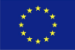    This work has been realised in the context of Odeuropa, a research project that has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No. 101004469.



---

